<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/PyTorch/Experiments/Transformer/TimeSeries/T03_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time Series

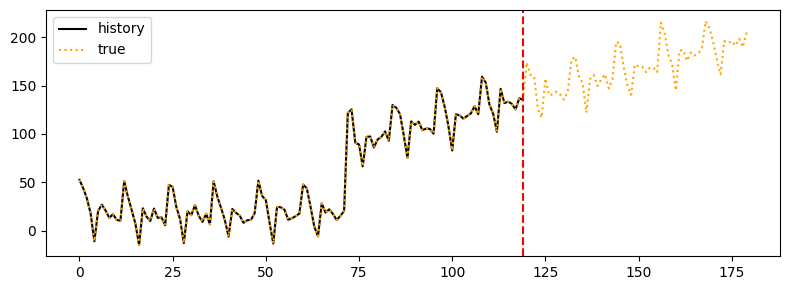

In [1]:
import numpy as np
np.random.seed(seed=42)
import matplotlib.pyplot as plt
import seaborn as sns

def trend(time):
    slope = np.zeros_like(a=time)
    slope[time < (3*12)] = 0.2
    slope[(time >= (3*12)) & (time < (6*12))] = -0.4
    slope[time >= (6*12)] = 1.0
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi),
        1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / float(period)
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=5):
    rnd = np.random.RandomState(seed=42)
    return rnd.randn(len(time)) * noise_level

period = 12; baseline = 10; amplitude = 40

time_history = np.arange(10*12)
ts_history = baseline + trend(time=time_history)\
    + seasonality(time=time_history, period=period, amplitude=amplitude)\
    + noise(time=time_history)
ts_history = ts_history.astype(np.float32)

time_true = np.arange(15*12)
ts_true = baseline + trend(time=time_true)\
    + seasonality(time=time_true, period=period, amplitude=amplitude)\
    + noise(time=time_true)
ts_true = ts_true.astype(np.float32)

plt.figure(figsize=(8, 3))
sns.lineplot(x=time_history, y=ts_history, label='history', color='black')
sns.lineplot(x=time_true, y=ts_true, label='true', color='orange',
    linestyle=':')
plt.axvline(x=time_history[-1], color='red', linestyle='--')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Dataset & DataLoader

In [2]:
import numpy as np
from sklearn import preprocessing
import torch
torch.manual_seed(seed=42)

x_len = 24; y_len = 1
ts_train = ts_history[:-12].reshape(-1, 1)
ts_test = ts_history[-(x_len + 12):].reshape(-1, 1)

scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X=ts_train)
ts_train = scaler.transform(X=ts_train)
ts_test = scaler.transform(X=ts_test)

class TrainingDataset(torch.utils.data.Dataset):
    def __init__(self, ts, x_len, y_len):
        super().__init__()
        self.ts = torch.tensor(data=ts, dtype=torch.float32)
        self.x_len = x_len; self.y_len = y_len
        self.indices = list(range(len(ts) - (x_len + y_len) + 1))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]

        x = self.ts[i : i + x_len]
        y = self.ts[i + x_len : i + x_len + y_len]

        return x, y

batch_size = 64
ds_train = TrainingDataset(ts=ts_train, x_len=x_len, y_len=y_len)
dl_train = torch.utils.data.DataLoader(dataset=ds_train, shuffle=False,
    batch_size=batch_size)

ds_test = TrainingDataset(ts=ts_test, x_len=x_len, y_len=y_len)
dl_test = torch.utils.data.DataLoader(dataset=ds_test, shuffle=False,
    batch_size=batch_size)

x, y = next(iter(dl_test))
x.shape, y.shape

(torch.Size([12, 24, 1]), torch.Size([12, 1, 1]))

## Model

In [12]:
import math
import torch
torch.manual_seed(seed=42)

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=20*12):
        super().__init__()
        pe = torch.zeros(size=(max_len, d_model))
        position = torch.arange(start=0, end=max_len,
            dtype=torch.float32).unsqueeze(dim=1)
        div_term = torch.exp(torch.arange(start=0, end=d_model, step=2)
            * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(dim=0))
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TimeSeriesForecast(torch.nn.Module):
    def __init__(self, in_dim=1, out_dim=1, d_model=32, max_len=24, dropout=0.2):
        super().__init__()
        self.input_layer = torch.nn.Linear(in_features=in_dim, out_features=d_model)

        self.pos_emb = torch.nn.Embedding(embedding_dim=d_model, num_embeddings=max_len)

        encoder_layer = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=2,
            dropout=dropout, batch_first=True)
        self.encoder = torch.nn.TransformerEncoder(num_layers=2, encoder_layer=encoder_layer)

        self.output_layer = torch.nn.Linear(in_features=d_model, out_features=out_dim)

    def forward(self, x):
        x = self.input_layer(x)

        pos = torch.arange(x.size(1), device=x.device)
        pos = self.pos_emb(pos)[None, :, :]

        x = x + pos
        x = self.encoder(x)

        return self.output_layer(x[:, -1:])

model = TimeSeriesForecast()
total_params = sum(p.numel() for p in model.parameters())
print("Total model parameters: %d"%(total_params))

y_pred = model(x=x)
y_pred.shape

Total model parameters: 275873


torch.Size([12, 1, 1])

## Training

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
torch.manual_seed(seed=42)

def train_step(model, dl_train, loss_fn, optimizer, device):
    model.train()
    losses = []
    for x, y in dl_train:
        x, y_true = x.to(device), y.to(device)
        y_pred = model(x=x)
        
        loss = loss_fn(input=y_pred, target=y_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def test_step(model, dl_test, loss_fn, device):
    model.eval()
    losses = []
    for x, y in dl_test:
        x, y_true = x.to(device), y.to(device)
        y_pred = model(x=x)

        loss = loss_fn(input=y_pred, target=y_true)
        losses.append(loss.item())
    return np.mean(losses)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
        elif loss < (self.best_loss - self.min_delta):
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def plot_history(history):
    df_history = pd.DataFrame(history)
    df_history.index.name = 'epoch'
    df_history.reset_index(inplace=True)

    plt.figure(figsize=(8, 3))
    sns.lineplot(data=df_history, x='epoch', y='train_loss', label='train')
    sns.lineplot(data=df_history, x='epoch', y='test_loss', label='test')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.title(label="loss vs. epoch")
    plt.xlabel(xlabel='epoch')
    plt.ylabel(ylabel='loss (log scale)')
    plt.tight_layout()
    plt.show()

Training finished in 92.91s, best_loss=0.033660


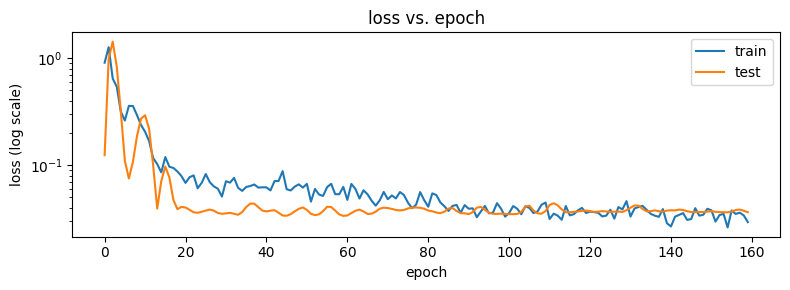

In [14]:
import os
import time
import pandas as pd
import torch
torch.manual_seed(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TimeSeriesForecast().to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
    mode='min', factor=0.9, patience=10)
early_stopping = EarlyStopping(patience=100, min_delta=1e-6)

num_epochs = 1000
os.makedirs('models', exist_ok=True)
model_path = 'models/timeseries_forecast.pth'

history = {'train_loss': [], 'test_loss': []}
best_loss = float('inf')
start_time = time.time()
for epoch in range(num_epochs):

    train_loss = train_step(model=model, dl_train=dl_train, loss_fn=loss_fn,
        optimizer=optimizer, device=device)
    history['train_loss'].append(train_loss)

    test_loss = test_step(model=model, dl_test=dl_test, loss_fn=loss_fn,
        device=device)
    history['test_loss'].append(test_loss)

    scheduler.step(metrics=test_loss)

    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(obj=model.state_dict(), f=model_path)

    early_stopping(loss=test_loss)
    if early_stopping.early_stop:
        break

total_time = time.time() - start_time
print("Training finished in %.2fs, best_loss=%.6f"%(total_time, best_loss))

plot_history(history=history)

## Forecasting

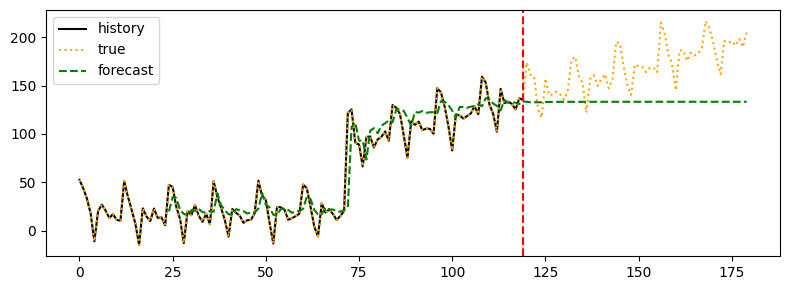

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
torch.manual_seed(seed=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = TimeSeriesForecast().to(device)
model.load_state_dict(torch.load(f=model_path, weights_only=True))

ts_scaled = ts_history.reshape(-1, 1)
ts_scaled = scaler.transform(X=ts_scaled)
ts_scaled = torch.tensor(data=ts_scaled, dtype=torch.float32).to(device)

len_idx = len(ts_scaled) - x_len + 1
idx = np.arange(stop=len_idx).reshape(-1, 1) + np.arange(stop=x_len)
x = ts_scaled[idx]

preds = []
model.eval()
with torch.no_grad():
    pred = model(x=x)
preds.append(pred[:, -1])
    

for _ in range(1, 5*12): 
    ts_scaled = torch.cat(tensors=[ts_scaled, pred[-1, -1:]], dim=0)
    x = ts_scaled[-x_len:].view(1, x_len, 1)
    with torch.no_grad():
        pred = model(x=x)
    preds.append(pred[:, -1])

preds = torch.cat(tensors=preds).squeeze()
ts_pred = scaler.inverse_transform(X=preds.reshape(-1, 1)).flatten()
time_pred = np.arange(start=(x_len+y_len-1),
    stop=(x_len+y_len-1) + len(ts_pred))

plt.figure(figsize=(8, 3))
sns.lineplot(x=time_history, y=ts_history, label='history', color='black')
sns.lineplot(x=time_true, y=ts_true, label='true', color='orange',
    linestyle=':')
sns.lineplot(x=time_pred, y=ts_pred, label='forecast', color='green', linestyle='--')
plt.axvline(x=time_history[-1], color='red', linestyle='--')
plt.legend(loc='best')
plt.tight_layout()
plt.show()